# Assignment 3: Unsupervised Learning

In this assignment you will:
* Implement K-means clustering and use it for color-quantization of images
* Train a MoG model by implementing the EM algorithm. Compare to K-means on the same test data. 
* Use MoG for image segmentation

# Part 1: K-Means Clustering

## Setup

First import the required packages and do some setup:

In [1]:
from __future__ import print_function

import sys
sys.path.append('./assignment3')

import time
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from assignment3 import kmeans, kmeans_colors, em_mog, em_segmentation

# Set default parameters for plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet'

%load_ext autoreload
%autoreload 2

Let's generate some test-data for you to test your implementation of the k-means and EM algorithm. Note that we generate gaussian blobs with non-isotropic covariance matrices. 

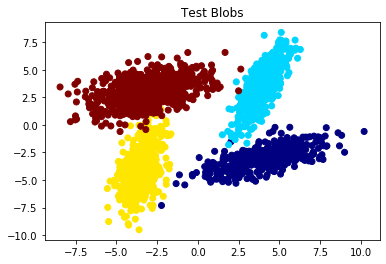

In [4]:
# Generate samples of 4 different gaussians
rv1 = multivariate_normal.rvs([4.0, -3.], [[4.0, 1.5], [1.5, 1.1]], size=400)
rv2 = multivariate_normal.rvs([4.0, 3.5], [[1.0, 2.3], [0.8, 2.75]], size=500)
rv3 = multivariate_normal.rvs([-3.5, -4.0], [[0.5, 1.0], [0.3, 3.]], size=600)
rv4 = multivariate_normal.rvs([-3., 3.], [[2.5, 0.1], [2.3, 1.5]], size=700)

# Concatenate the samples and create corresponding labels
X = np.concatenate([rv1, rv2, rv3, rv4], 0)
y = np.array([0]*400+[1]*500+[2]*600+[3]*700)

# Plot the test data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Test Blobs")
plt.show()

## Exercise 1: K-Means Clustering [15 Points]

You will now implement the standard k-means clustering algorithm and test it on the generated test data. 

**TODO**: Implement the k-means clustering algorithm in ***kmeans.py*** accroding to specs and test your implementation with the provided test data.


Number of iterations: 4, Execution time: 0.05942130088806152s


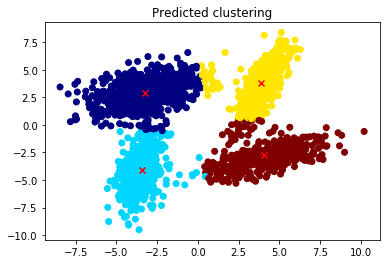

In [5]:
# Test your implementation
centers, assign = kmeans(X, 4)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=assign)
plt.scatter(centers[:, 0], centers[:, 1], c='r', marker='x')
plt.title("Predicted clustering")
plt.show()

## Exercise 2: Questions about K-means [10 Points]

* Does k-means always result in the same clustering? Why?

***Your Answer:***

Because of random initialization of centroids at the start of algorithm, different initializations may lead to different clusters, since K-means algorithm may get stuck on local optimum instead of converging to global optimum.


* Would you expect K-means to work better in the case of data generated from isotropic gaussian distributions? Why?

***Your Answer:***

One of the assumptions of K-means is that clusters are of circular shape. With isotropic gaussian distributions this assumption is met, which should lead to better results

## Exercise 3: Using k-means for image compression [10 Points]

You will now use K-means to cluster pixel values of an image and use the cluster assignments as a way to quantize/compress the color-space of the image. Replace each pixel with the mean of the assigned cluster.
You should use the implementation provided through sklearn in this exercise ([sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)).

Feel free to test the algorithm on your own images and with different number of clusters.

**TODO**: Implement the color-quantization through k-means in ***kmeans_colors.py*** according to specs. 


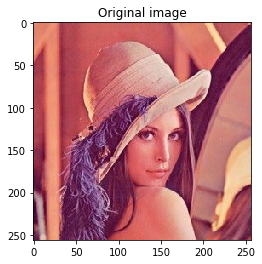

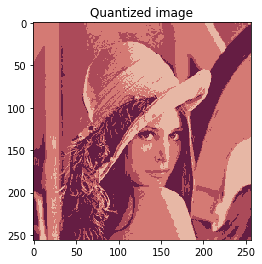

In [6]:
# Load and show test image
img = imageio.imread('lena.jpg')
plt.imshow(img)
plt.title("Original image")
plt.show()

# Compute quantized image
k = 4
img_cl = kmeans_colors(img, k)

# Show the quantized image
plt.imshow(img_cl)
plt.title("Quantized image")
plt.show()

# Part 2: Expectation Maximization

In the second part of the assignment you will implement the EM algorithm for Mixture of Gaussian (MoG) models. You will then use this model on the problem of image-segmentation.


## Exercise 4: EM for MoG [25 Points]

**TODO:** Implement the **EM** algorithm for Mixture of Gaussian models in **em_mog.py** according to specs. Test your implementation on the provided test data.  

Iter: 1/20, LL: -10743.88889400878
Iter: 2/20, LL: -10603.589812726239
Iter: 3/20, LL: -10627.505252962832
EM has converged...
Number of iterations: 3, Execution time: 2.9756722450256348s


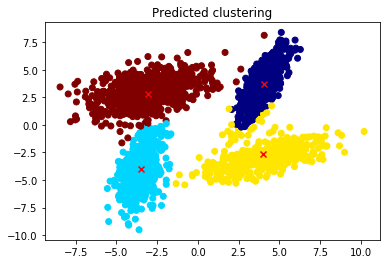

In [7]:
# Test your implementation
phi, mu, sigma, w = em_mog(X, 4)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(w, 1))
plt.scatter(mu[:, 0], mu[:, 1], c='r', marker='x')
plt.title("Predicted clustering")
plt.show()

## Exercise 5: Estimating Clustering Quality: K-Means VS RM [15 Points]

Compare cluster assignment that you get with K-Means and EM algorithm. In order to do so you need to first implement Normalized Mutual Information Score defined as follows:

\begin{equation}
N M I(Y, C)=\frac{2 \times I(Y ; C)}{[H(Y)+H(C)]}
\end{equation}

where 
* Y is a class label
* C is a cluster label
* H(Y) is Entropy of class labels 
* H(C) is Entropy of cluster labels 
* I(Y ; C) is a mutual information

<span style="color:red">You are not allowed to use function sklearn.metrics.normalized_mutual_info_score!</span>
<span style="color:red">You can use following functions to complete the code:</span>
* sklearn.metrics.mutual_info_score
* scipy.stats.entropy

As a test case try to run the following code:
<span style="color:red">print(normalized_mutual_info_score(np.array([3,2,1,0]), np.array([0,1,2,3])))</span>

The results of this code must be 1.0

In [8]:
import seaborn as sns; sns.set()
from scipy.stats import mode, entropy
from sklearn.metrics import accuracy_score, mutual_info_score, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import multivariate_normal

def pk(labels):
    """
    Computes probabilities pk
    
    Args:
        labels: labels as int array, shape = [n_samples]
    """
    pi = np.bincount(labels)
    return pi / np.sum(pi)

def normalized_mutual_info_score(x1,x2):
    """
    Computes Normalized Mutual Information Score between x1 and x2.

    Args:
        x1: Ground-Truth Labels
        x2: Predicted Clusters

    Returns:
        nmis: Normalized Mutual Information Score between x1 and x2

    """
    nmis = None
    
    #######################################################################
    # TODO:                                                               #
    # Compute Normalized Mutual Information Score between x1 and x2        #
    #                                                                     #
    #######################################################################
    ent_x1 = entropy(pk(x1))
    ent_x2 = entropy(pk(x2))
    
    nmis = (2 * mutual_info_score(x1, x2)) / (ent_x1 + ent_x2)
    
    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    
    return nmis

# Test nmis
print('test code',normalized_mutual_info_score(np.array([3,2,1,0]), np.array([0,1,2,3])))

methods = ['kmeans','em']

N = 4

# Generate samples of 4 different gaussians
rv1 = multivariate_normal.rvs([4.0, -3.], [[4.0, 1.5], [1.5, 1.1]], size=400)
rv2 = multivariate_normal.rvs([4.0, 3.5], [[1.0, 2.3], [0.8, 2.75]], size=500)
rv3 = multivariate_normal.rvs([-3.5, -4.0], [[0.5, 1.0], [0.3, 3.]], size=600)
rv4 = multivariate_normal.rvs([-3., 3.], [[2.5, 0.1], [2.3, 1.5]], size=700)

# Concatenate the samples and create corresponding labels
X = np.concatenate([rv1, rv2, rv3, rv4], 0)
y = np.array([0]*400+[1]*500+[2]*600+[3]*700)

for method in methods:
    if method == 'kmeans':
        centers, assign = kmeans(X, N)
    elif method == 'em':
        phi, mu, sigma, w = em_mog(X, N)
        assign = np.argmax(w,axis=1)
    
    print('Normalized Mutual Information Score for %s=%.2f' % (method,normalized_mutual_info_score(y, assign)))  


test code 1.0
Number of iterations: 4, Execution time: 0.05713391304016113s
Normalized Mutual Information Score for kmeans=0.88


/home/fabienne/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Iter: 1/20, LL: -10761.651006525528
Iter: 2/20, LL: -10735.95285468536
Iter: 3/20, LL: -10781.056781115278
EM has converged...
Number of iterations: 3, Execution time: 3.528334140777588s
Normalized Mutual Information Score for em=0.91



## Exercise 6: Questions about MoG [10 Points]

* Does the MoG model perform better on the provided test data? Why?

***Your Answer:***

Yes, MoG allows clusters to overlap and can account for ellipsoidal shape of data groups.

* What are advantages and disantages of MoG vs. K-means?

***Your Answer:***

- MoG allows overlap by using soft cluster assignment.
- MoG doesn't assume shape for clusters, making it more flexible.
- K-means is easier to understand.
- K-means assumes spherical clusters, making it less efficient with data of complex shape.
- K-means does not allow overlap which can lead to misclassification.
- K-means is faster but less accurate.


## Exercise 7: Image Segmentation with MoG [15 Points]

Image segmentation is the process of partitioning an image into multiple segments. The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.

In this exercise you will implement image segmentation by fitting a MoG model via EM. For this you will not only cluster the pixel colors (RGB) but extend the pixel features with their 2D coordinates. Hence, the clustered pixel features are of the form RGBXY. This allows for additional locality of the segments.

You should use the implementation provided through sklearn in this exercise ([sklearn.mixture.GaussianMixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)).

Feel free to test the algorithm on your own images and with different number of segments.

**TODO:** Implement the image-segmentation in ***em_segmentation.py*** according to specs.  

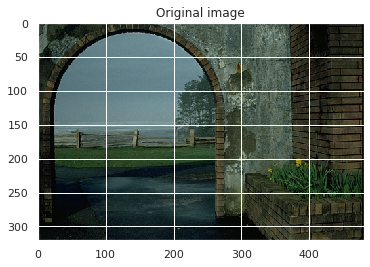

/home/fabienne/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


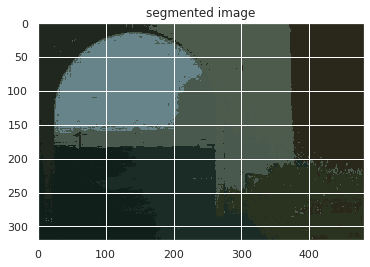

In [9]:
# Load and show test image
img = imageio.imread('test.jpg')
plt.imshow(img)
plt.title("Original image")
plt.show()

# Compute segmented image
img_seg = em_segmentation(img, 8)
plt.imshow(img_seg)
plt.title("segmented image")
plt.show()